# Отчет по Рубежному контролю №2

> Канаев А.И. ИУ5-36Б

## 1. Использование внешних библиотек на примере ncurses


3. С использованием библиотеки ncurses реализовать движение курсора так, чтобы оставшихся след давал букву $V$.

## 2. Процессы

3. В программе на ассемблере заполнить массив случайными числами в количестве $N$ (вводится параметром командной строки), вывести полученный массив на экран. Создать два дочерних процесса (clone). Один дочерний процесс должен сортировать все числа стоящие на четных позициях, второй - на нечетных позициях.  По окончанию работы дочерных процессов родительский процесс должен вывести получившийся массив на экран.

## Генерация заданий по варианту

In [2]:
import random as rd

Variant = 12

rd.seed(Variant+634)

Numbers_of_problems = [rd.sample(range(3),1)[0]+1, rd.sample(range(3),1)[0]+1]
Numbers_of_problems

[3, 3]

## Задание 1.3
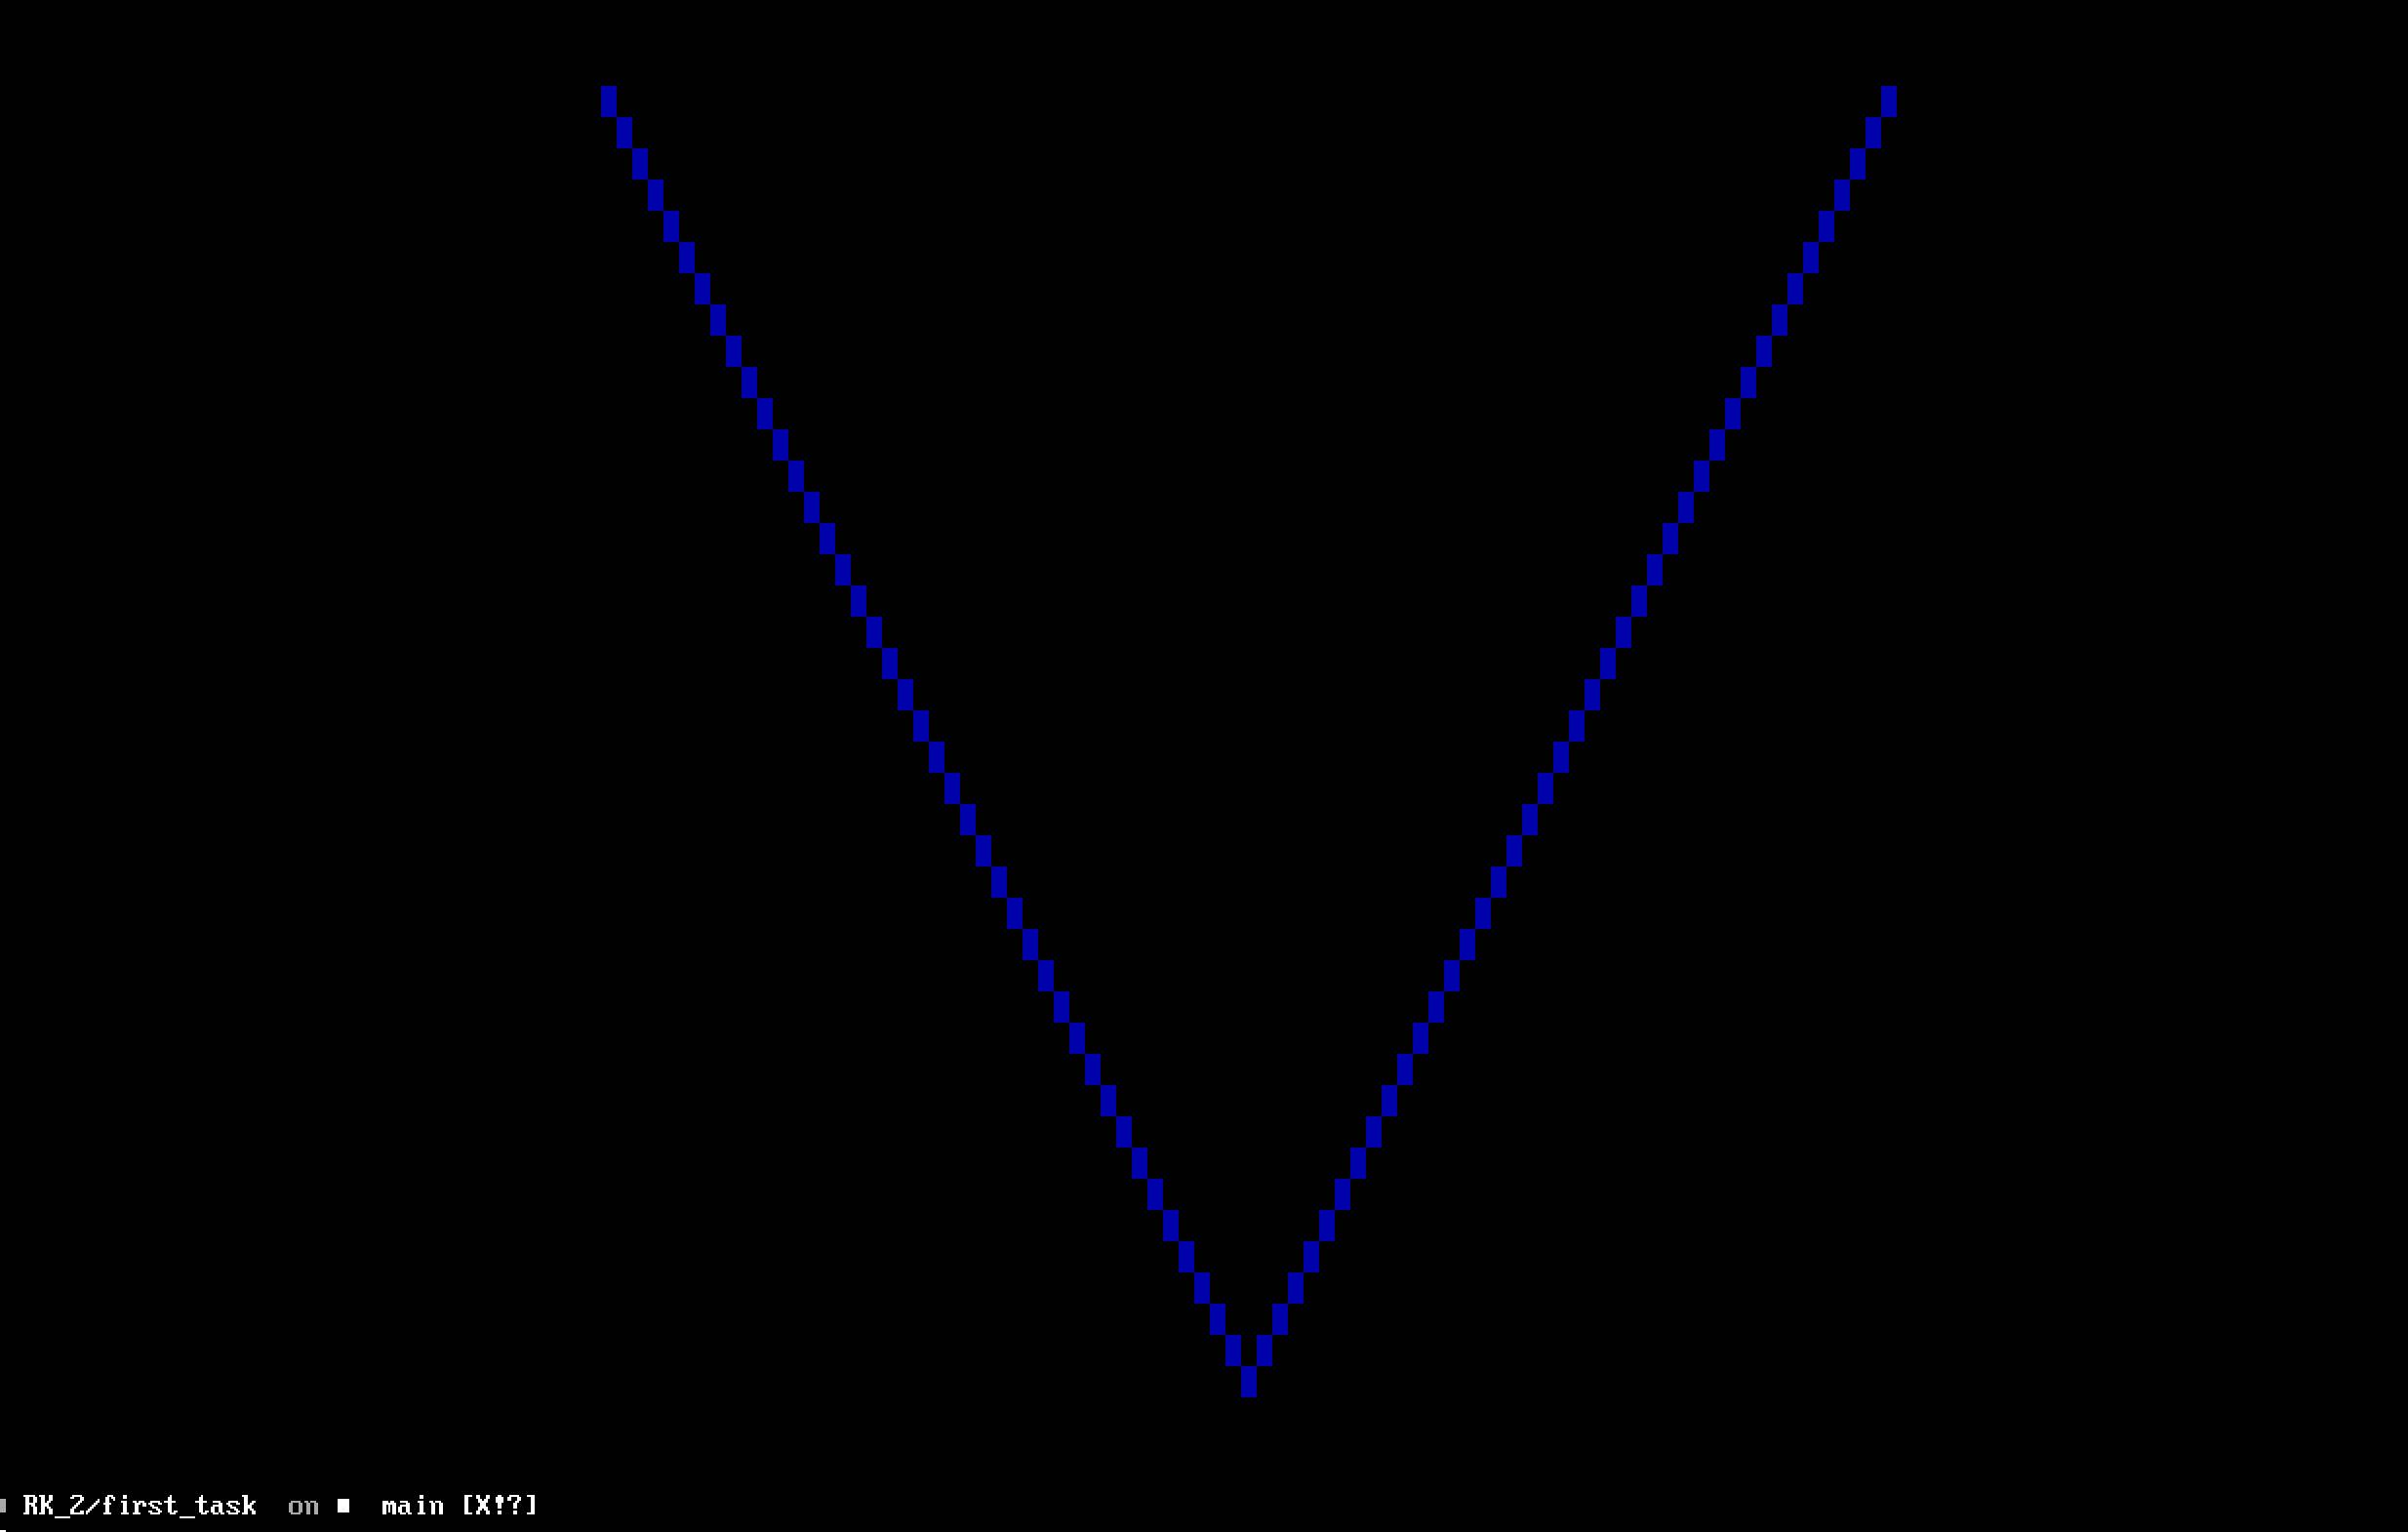

## Задание 2.3

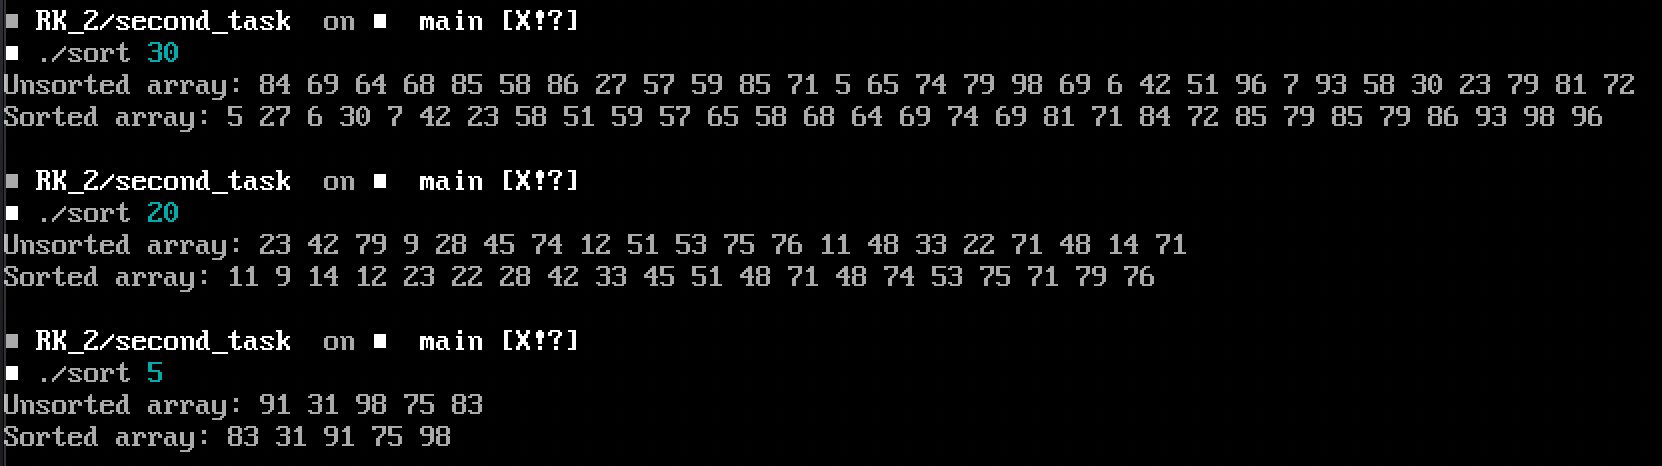

## Code

### v_shape.asm

```nasm
format ELF64


extrn initscr
extrn endwin
extrn refresh
extrn move
extrn addch
extrn getch
extrn noecho
extrn curs_set
extrn napms

extrn start_color
extrn init_pair
extrn attron
extrn attroff
extrn getmaxy
extrn getmaxx
extrn stdscr

public _start

section '.data' writable
    delay_ms dq 50
    
    yMax     dq 0
    xMax     dq 0
    
    base_y   dq 0
    base_x   dq 0
    
    curr_y   dq 0
    curr_x   dq 0

    
    COLOR_BLUE  equ 4
    COLOR_WHITE equ 7
    PAIR_ID     equ 1

section '.text' executable

_start:
    
    call initscr
    call noecho
    mov rdi, 0
    call curs_set

    
    call start_color
    
    
    mov rdi, PAIR_ID
    mov rsi, COLOR_WHITE
    mov rdx, COLOR_BLUE  
    call init_pair

    
    
    mov rdi, 0x100
    call attron

    
    mov rdi, [stdscr]
    call getmaxy
    mov [yMax], rax

    mov rdi, [stdscr]
    call getmaxx
    mov [xMax], rax

    
    
    mov rax, [yMax]
    sub rax, 4
    mov [base_y], rax
    
    
    mov rax, [xMax]
    shr rax, 1
    mov [base_x], rax

    
    
    mov r12, [base_y]  
    mov r13, [base_x]  

.left_loop:
    
    cmp r12, 4
    jle .start_right
    cmp r13, 4
    jle .start_right

    
    mov rdi, r12
    mov rsi, r13
    call move

    
    mov rdi, ' '
    call addch

    call refresh

    
    mov rdi, [delay_ms]
    call napms

    
    dec r12
    dec r13
    jmp .left_loop

    
.start_right:
    
    mov r12, [base_y]
    mov r13, [base_x]
    
    
    dec r12
    inc r13

.right_loop:
    
    cmp r12, 4
    jle .finish

    
    mov rax, [xMax]
    sub rax, 4
    cmp r13, rax
    jge .finish

    
    mov rdi, r12
    mov rsi, r13
    call move

    
    mov rdi, ' '
    call addch

    call refresh

    mov rdi, [delay_ms]
    call napms

    
    dec r12
    inc r13
    jmp .right_loop

    
.finish:
    
    mov rdi, 0x100
    call attroff

    call getch
    call endwin
    
    
    mov rax, 60
    xor rdi, rdi
    syscall
```

### arr_sort.asm

```nasm
format ELF64
public _start

section '.data' writeable
    array_ptr       dq 0
    array_len       dq 0
    child1_pid      dq 0
    child2_pid      dq 0
    msg_usage       db 'Args: ./program <N>', 10, 0
    msg_array_label db 'Sorted array: ', 0
    msg_array_label0 db 'Unsorted array: ', 0
    msg_space       db ' ', 0
    newline         db 10, 0
    dev_urandom     db '/dev/urandom', 0


section '.bss' writable
    child1_stack    rb 8192
    child2_stack    rb 8192
    fmt_num_buf     rb 20

section '.text' executable

_start:
    mov rdi, [rsp]
    cmp rdi, 2
    jne show_usage

    mov rsi, [rsp+16]
    call atoi
    mov [array_len], rax

    ; --- Выделение памяти ---
    mov rdi, [array_len]
    shl rdi, 3          ; *8
    mov rax, 9          ; SYS_MMAP
    mov rsi, rdi        ; length
    mov rdx, 3          ; PROT_READ | PROT_WRITE
    mov r10, 33         ; MAP_SHARED | MAP_ANONYMOUS (33 = 0x21)
    mov r8, -1
    mov r9, 0
    syscall

    test rax, rax
    js exit_error       ; Если ошибка (отрицательный результат)
    mov [array_ptr], rax

    ; --- Заполнение рандомом ---
    
    mov rax, 2          ; SYS_OPEN
    lea rdi, [dev_urandom]
    mov rsi, 0          ; O_RDONLY
    syscall
    mov r8, rax         

    ; Читаем N*8 байт прямо в массив
    mov rax, 0          ; SYS_READ
    mov rdi, r8
    mov rsi, [array_ptr]
    mov rdx, [array_len]
    shl rdx, 3          ; *8 байт
    syscall

    
    mov rax, 3          ; SYS_CLOSE
    mov rdi, r8
    syscall
    
    ;нормализация
    mov rcx, [array_len]
    mov rbx, [array_ptr]
    .norm_loop:
        mov rax, [rbx]
        and rax, 0x7FFFFFFF ; Убираем знак
        xor rdx, rdx
        mov rdi, 100
        div rdi
        mov [rbx], rdx      
        add rbx, 8
        loop .norm_loop

    mov rsi, msg_array_label0
    call print_string
    mov rcx, [array_len]
    mov rbx, [array_ptr]
    .print_loop:
        mov rax, [rbx]
        call print_uint
        mov rsi, msg_space
        call print_string
        add rbx, 8
        loop .print_loop

        call print_newline


    ; Ребенок 1 (Четные)
    mov rax, 56         ; SYS_CLONE
    mov rdi, 0x100 or 17 ; CLONE_VM | SIGCHLD
    lea rsi, [child1_stack + 8192] ; Вершина стека
    xor rdx, rdx
    xor r10, r10
    xor r8, r8
    syscall

    test rax, rax
    jz process_even     
    mov [child1_pid], rax

    ; Ребенок 2 (Нечетные)
    mov rax, 56
    mov rdi, 0x100 or 17
    lea rsi, [child2_stack + 8192]
    xor rdx, rdx
    xor r10, r10
    xor r8, r8
    syscall

    test rax, rax
    jz process_noteven
    mov [child2_pid], rax

    
    mov r12, 2
    .wait_loop:
        mov rax, 61
        mov rdi, -1
        mov rsi, 0
        mov rdx, 0
        mov r10, 0
        syscall

        dec r12
        jnz .wait_loop

        mov rsi, msg_array_label
        call print_string

        mov rcx, [array_len]
        mov rbx, [array_ptr]
    .print1_loop:
        mov rax, [rbx]
        call print_uint
        mov rsi, msg_space
        call print_string
        add rbx, 8
        loop .print1_loop

        call print_newline
        call exit

show_usage:
    mov rsi, msg_usage
    call print_string
    call exit_error

process_even:
    mov rbx, [array_ptr]
    mov rcx, [array_len]
    
    .outer_loop:
        mov r8, 0        ; четный
        mov r9, 0        ; n_swap
    .inner_loop:
        mov r10, r8
        add r10, 2       
        
        cmp r10, rcx    
        jge .check_swap
        
        ; arr[i] ? arr[j]
        mov rax, [rbx + r8*8]
        mov rdx, [rbx + r10*8]
        
        cmp rax, rdx
        jle .noswap
        
       
        mov [rbx + r8*8], rdx
        mov [rbx + r10*8], rax
        mov r9, 1        
        
    .noswap:
        add r8, 2 ; step = 2
        jmp .inner_loop
        
    .check_swap:
        cmp r9, 0        
        jne .outer_loop  
        
    call exit_thread

process_noteven:
    mov rbx, [array_ptr]
    mov rcx, [array_len]
    
    .outer_loop:
        mov r8, 1        ; нечетный
        mov r9, 0        ;n_swap = 0
    .inner_loop:
        mov r10, r8
        add r10, 2       
        
        cmp r10, rcx     
        jge .check_swap
        
        
        mov rax, [rbx + r8*8]
        mov rdx, [rbx + r10*8]
        
        cmp rax, rdx
        jle .noswap      
        
        
        mov [rbx + r8*8], rdx
        mov [rbx + r10*8], rax
        mov r9, 1        
        
    .noswap:
        add r8, 2        
        jmp .inner_loop
        
    .check_swap:
        cmp r9, 0        
        jne .outer_loop  
        
    call exit_thread
atoi:
    xor rax, rax

    .atoi_loop:
        movzx rdi, byte [rsi]
        inc rsi
        cmp rdi, '0'
        jb .atoi_done
        cmp rdi, '9'
        ja .atoi_done
        sub rdi, '0'
        imul rax, 10
        add rax, rdi
        jmp .atoi_loop
    .atoi_done:
        ret

print_string:
    push rdi
    push rax
    push rdx
    push rcx
    mov rdi, rsi
    call strlen
    mov rdx, rax
    mov rax, 1
    mov rdi, 1
    syscall
    pop rcx
    pop rdx
    pop rax
    pop rdi
    ret

print_newline:
    mov rsi, newline
    call print_string
    ret

print_uint:
    push rbx
    push rcx
    push rdx
    push rsi
    push rdi
    mov rbx, 10
    mov rcx, fmt_num_buf
    add rcx, 19
    mov byte [rcx], 0

    .convert_loop:
        dec rcx
        xor rdx, rdx
        div rbx
        add dl, '0'
        mov [rcx], dl
        test rax, rax
        jnz .convert_loop
        mov rsi, rcx
        call print_string
        pop rdi
        pop rsi
        pop rdx
        pop rcx
        pop rbx
        ret

strlen:
    xor rax, rax

    .loop:
        cmp byte [rdi + rax], 0
        je .done
        inc rax
        jmp .loop
    .done:
        ret

exit_thread:
    mov rax, 60
    xor rdi, rdi
    syscall

exit_error:
    mov rax, 60
    mov rdi, 1
    syscall

exit:
    mov rax, 60
    xor rdi, rdi
    syscall
```